# Import Library

In [2]:
import pandas as pd
import nltk
import re
import emoji
import ast

# Drop Unsed Column

In [ ]:
file_path = r".\Ori_Emotion_Dataset\Emotions.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5)
# drop sadness , love , surprise emotion label
data = data.drop(data[data['label'].isin([0, 2, 5])].index)
output_file =r".\Pre_Emotion_Dataset\1_drop_column.csv"
data.to_csv(output_file, index=False, encoding='ISO-8859-1')

# Check & Remove Duplicated

In [ ]:
num_duplicates = data.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 418


In [ ]:
# remove duplicated
data = data.drop_duplicates()
num_duplicates_after = data.duplicated().sum()
print(f"Number of duplicated rows after removal: {num_duplicates_after}")
data.info()
output_file =r".\Pre_Emotion_Dataset\2_remove_duplicated.csv"
data.to_csv(output_file, index=False, encoding='ISO-8859-1')

Number of duplicated rows after removal: 0
<class 'pandas.core.frame.DataFrame'>
Index: 245678 entries, 0 to 416807
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    245678 non-null  object
 1   label   245678 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.6+ MB


# Emotion Label Remapping

In [ ]:
# Emotion Label Remapping: joy (1 → 0), anger (3 → 1), fear (4 → 2)
label_mapping = {1: "joy → 0", 3: "anger → 1", 4: "fear → 2"}

# Print label distribution before mapping
print("📌 Original label distribution:")
print(data['label'].value_counts())

# Apply label mapping
data['label'] = data['label'].replace({1: 0, 3: 1, 4: 2})

# Print label distribution after mapping
print("\n📌 New label distribution:")
print(data['label'].value_counts())

output_file = r".\Pre_Emotion_Dataset\3_label_remapping.csv"
data.to_csv(output_file, index=False, encoding='ISO-8859-1')



📌 Original label distribution:
label
1    140779
3     57235
4     47664
Name: count, dtype: int64

📌 New label distribution:
label
0    140779
1     57235
2     47664
Name: count, dtype: int64


# Remove  ASCII characters/URLs/Emoji/whitespace...

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

file_path =r".\Pre_Emotion_Dataset\3_label_remapping.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
# df['text'].astype(str)

# Remove ASCII characters & delete unused punctuation
df['text'] = df['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]', '', str(x)))

# Remove URLs
df['text'] = df['text'].apply(lambda x: re.sub(r'(http|https|www)\S+', '', str(x)))

# Remove HTML
html_tags_pattern = r'<.*?>'
# sub(pattern,replace,text)
df['text'] = df['text'].apply(lambda x: re.sub(html_tags_pattern, '', str(x)))
df['text'] = df['text'].apply(lambda x: re.sub(r'\S+html\b', '', str(x)))

# Remove emojis
def remove_emojis(text):
    text = emoji.demojize(text)
    text = re.sub(r':\w+:', '', text)
    return text
df['text'] = df['text'].apply(remove_emojis)

# Remove excessive whitespace
# .strip() removes any leading or trailing whitespace from the text
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Remove only number rows
only_numbers_df = df[df['text'].astype(str).str.strip().str.isdigit()]
print(only_numbers_df)
df = df[~df['text'].astype(str).str.strip().str.isdigit()] #turn all data into string (astype(str), remove space (strip()), check is whole string is digit)

# Remove repeated punctuation
df['text'] = df['text'].apply(lambda x: re.sub(r'([.!?])\s*\1+', r'\1', x))

# Removing elongation (example: goodddddddddd)
df['text'] = df['text'].apply(lambda x: re.sub(r'(.)\1{2,}', r'\1\1', x))

# Save to a new CSV file
output_file = r".\Pre_Emotion_Dataset\4_remove.csv"
df.to_csv(output_file, index=False, encoding="utf-8")
print(f"Data has been saved to {output_file}")


Empty DataFrame
Columns: [text, label]
Index: []
Data has been saved to .\Pre_Emotion_Dataset\4_remove.csv


# Check NA

In [ ]:
file_path = r".\Pre_Emotion_Dataset\4_remove.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')
print("\nMissing values per column:\n", data.isnull().sum())


Missing values per column:
 text     0
label    0
dtype: int64


# Replace Abbreviations

In [ ]:
# Replace Abbreviations
file_path =  r".\Pre_Emotion_Dataset\4_remove.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Abbreviations List Get from (Pallavi Padav, 2024) and base on EDA unknown word
abbreviations = {
    "arent": "are not","werent":"were not",
    "isnt": "is not","wasnt":"was not",
    "wont": "will not",
    "wouldve":"would have",
    "couldve":"could have",
    "couldnt": "could not",
    "wouldnt": "would not",
    "shouldnt": "should not",
    "cant": "can not",
    "hadnt":"had not",
    "hasnt":"has not",
    "shes": "she is","hes": "he is",
    "youre": "you are","youve": "you have", "yall":"you all","youll":"you will",
    "theyve":"they have", "theyd":"they had",
    "doesnt": "does not","dont": "do not","didnt": "did not",
    "im": "i am", "she's": "she is","he's": "he is",
    "ive": "i have", "id": "i would",
    "itll":"it will", "itd":"it had",
    "wth":"what the heal","wtf":"what the fuck",
    "fk":"fuck","fked":"fuck","fuk":"fuck","fck":"fuck", "fcking":"fucking","fuckin":"fuck",
    "thats":"that is",
    "jk":"just kidding",
    "cuz":"because",
    "bcuz":"because",
    "fb":"facebook",
    "u":"you",
    "lol":"laughing out loud",
    "lmao":"laughing my ass off",
    "omg ":"oh my god",
    "bro":"brother",
    "tbh":"to be honest",
    "idk":"i do not know",
    "congrats":"congratulations",
    "upvote":"up vote",
    "downvote":"down vote","downvoted":"down vote",
    "btw":"by the way",
    "etc":"et cetera",
    "img":"image",
    "href":"",
    "http":"",
    "src":"",
    "ww":"",
}

def replace_abbreviations(text):
    text = str(text)
    for abbr, full_form in abbreviations.items():
        text = re.sub(r'\b' + re.escape(abbr) + r'\b', full_form, text)
    return str(text)

df['text'] = df['text'].apply(replace_abbreviations)

output_file = r".\Pre_Emotion_Dataset\5_Replace_Abbreviations.csv"
df.to_csv(output_file, index=False, encoding="utf-8")
print(f"Data has been saved to {output_file}")

Data has been saved to .\Pre_Emotion_Dataset\5_Replace_Abbreviations.csv


# Tokenization

In [23]:
# Tokenization
file_path =  r".\Pre_Emotion_Dataset\5_Replace_Abbreviations.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
filteredTokens = []
for token in df['text']:
    token = str(token)
    wordtokens = nltk.tokenize.word_tokenize(token)
    filteredTokens.append(wordtokens)
df['text']=filteredTokens

output_file = r".\Pre_Emotion_Dataset\6_Tokenization.csv"
df.to_csv(output_file, index=False, encoding="utf-8")
print(f"Data has been saved to {output_file}")


Data has been saved to .\Pre_Emotion_Dataset\6_Tokenization.csv


# Remove Stop Word

In [24]:
# Remove Stop Word
file_path = r".\Pre_Emotion_Dataset\6_Tokenization.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert strings back to lists, stored as strings in the CSV file
df['text'] = df['text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

stopTokens = nltk.corpus.stopwords.words("english")

stopTokens.remove('not') 
stopTokens.remove('no') 

def removeStopWord(words):
    return [word for word in words if word.lower() not in stopTokens]
df['text'] = df['text'].apply(removeStopWord)

output_file = r".\Pre_Emotion_Dataset\7_Remove_StopWord.csv"
df.to_csv(output_file, index=False, encoding="utf-8")
print(f"Data has been saved to {output_file}")

Data has been saved to .\Pre_Emotion_Dataset\7_Remove_StopWord.csv


# Lemmatization

In [25]:
# 17. Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pandas as pd
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') #used for Part-of-Speech (POS) tagging

lemmatizer = WordNetLemmatizer()

def get_pos_tagging(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if no match

def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word, get_pos_tagging(word)) for word in text] 
    return ' '.join(lemmatized_words)
df['text'] = df['text'].apply(lemmatize_text)

output_file =r".\Pre_Emotion_Dataset\8_Lemmatization.csv"
df.to_csv(output_file, index=False, encoding="utf-8")
print(f"Data has been saved to {output_file}")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Data has been saved to .\Pre_Emotion_Dataset\8_Lemmatization.csv


## Last Check

In [3]:
checkNull_file_path = r".\Pre_Emotion_Dataset\8_Lemmatization.csv"
checkNull = pd.read_csv(checkNull_file_path, encoding='ISO-8859-1')
checkNull.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
# drop na
file_path = r".\Pre_Emotion_Dataset\8_Lemmatization.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')

print("\nMissing values per column:\n",data.isnull().sum())
data = data.dropna(subset=['text'])

print("\nMissing values per column after dropping NaN:\n",data.isnull().sum())
# data.info()
output_file =r".\Pre_Emotion_Dataset\8_Lemmatization.csv"
data.to_csv(output_file, index=False, encoding='ISO-8859-1')



Missing values per column:
 text     0
label    0
dtype: int64


In [8]:
# Check Dup
file_path = r".\Pre_Emotion_Dataset\8_Lemmatization.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')

num_duplicates = data.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")


Number of duplicated rows: 9694


In [6]:
# remove duplicated
data = data.drop_duplicates()
num_duplicates_after = data.duplicated().sum()
print(f"Number of duplicated rows after removal: {num_duplicates_after}")
data.info()
output_file =r".\Pre_Emotion_Dataset\8_Lemmatization_new.csv"
data.to_csv(output_file, index=False, encoding='ISO-8859-1')

Number of duplicated rows after removal: 0
<class 'pandas.core.frame.DataFrame'>
Index: 235972 entries, 0 to 245665
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    235972 non-null  object
 1   label   235972 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.4+ MB


# EDA After Text Preprocessing

## Unknown Word

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


             word  frequency
2          others       2344
8     overwhelmed       1785
25             et        627
26         cetera        619
29       facebook        437
41       blogging        430
27        happens        411
237           soo        314
1002           gt        263
433          haha        234
249      betrayed        195
46           alot        180
904        brings        174
21         judged        170
175        feelin        166
104        allows        138
573        deeper        131
592    challenged        130
396     everytime        125
3           dunno        120
501            dr        118
159           pre        114
247            lt        111
536         obama        106
199      deserves        105
205           lil        104
571       reminds         96
121           ups         95
208         safer         95
242     everyones         92
31          elses         88
279       youtube         86
543       hardest         83
7             

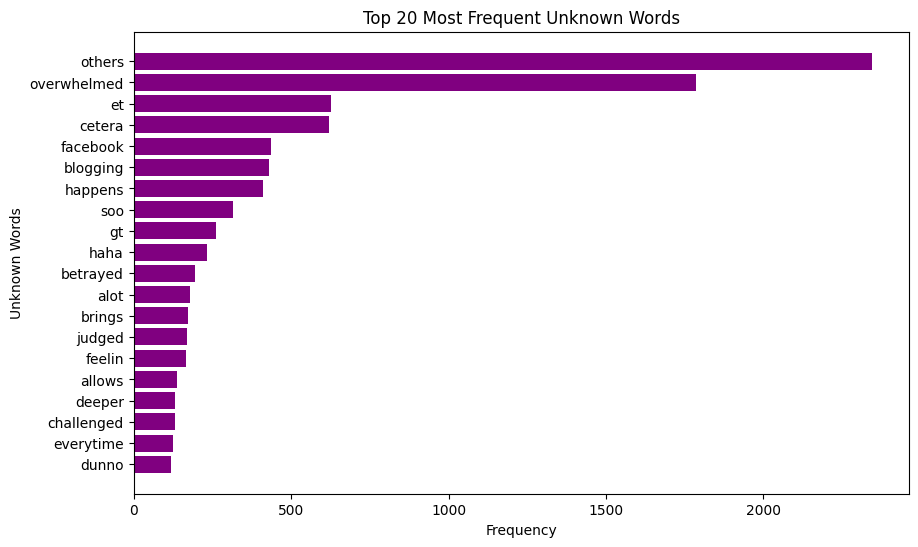

In [29]:
# unknow word
import pandas as pd
import re
from nltk.corpus import wordnet, words
import nltk
from collections import Counter
import matplotlib.pyplot as plt

nltk.download('wordnet')
nltk.download('words')

file_path = r".\Pre_Emotion_Dataset\8_Lemmatization.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)
text_data = data['text']

# Combine WordNet and NLTK word list vocabularies
combined_vocab = set(words.words()) | set(wordnet.words())

def find_unknown_words_combined(text):
    if not isinstance(text, str):  # Skip non-string values
        return []
    words_in_text = re.findall(r'\b\w+\b', text.lower())  # Extract words (ignoring punctuation)
    return [word for word in words_in_text if word not in combined_vocab]

data['unknown_words'] = data['text'].apply(find_unknown_words_combined)

# Flatten all unknown words into a single list
all_unknown_words = [word for words in data['unknown_words'] for word in words]

# Calculate the frequency of each unknown word
unknown_word_freq = Counter(all_unknown_words)

# Convert frequency to a DataFrame for visualization
freq_df = pd.DataFrame(unknown_word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
print(freq_df.head(100))

top_unknown = freq_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_unknown['word'], top_unknown['frequency'], color='purple')
plt.xlabel('Frequency')
plt.ylabel('Unknown Words')
plt.title('Top 20 Most Frequent Unknown Words')
plt.gca().invert_yaxis()  # Display the most frequent at the top
plt.show()
